# 3. Дообучение модели на оценках эксперта

Дообучать на локальном компьютере без GPU оказалось нереально долго. Пришлось перейти на Google Colab и арендовать GPU. Для нашего датасета оказалось достаточно T4 с GPU RAM 15 Gb. Расход примерно 1.19 единиц в час, не разорительно.

Как показали уже выполненные прогоны, версии transformers старше 4.57.1 выдают ошибку ERROR:sentence_transformers.trainer:Could not load the best model from checkpoint Error: 'dict' object has no attribute 'model_type'

Здесь https://github.com/huggingface/transformers/issues/42374 рекомендуют загрузить предыдущую версию 4.57.1

In [ ]:
import transformers

print(transformers.__version__)

if transformers.__version__ != "4.57.1":
    %pip install transformers==4.57.1

4.57.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%run drive/MyDrive/Netology/CY/utils.ipynb # Константы и вспомогательные функции

In [ ]:
DATA_DIR

'../data/'

In [ ]:
DATA_DIR = 'drive/MyDrive/Netology/CY/' # переопределим на время работы с Colab

## 3.1 Загружаем драгоценные оценки эксперта

In [ ]:
import pandas as pd
scores = pd.read_csv(DATA_DIR + 'pairs_with_expert_scores.csv')
scores

,id1,id2,score_expert
0,IBM-6627,IBM-4382,3.0
1,IBM-7350,IBM-9347,6.0
2,CY-2578,CY-1871,8.0
3,IBM-8043,IBM-7892,8.0
4,IBM-8043,IBM-7898,9.0
...,...,...,...
639,IBM-4418,IBM-4421,NaN
640,CY-3885,IBM-1750,NaN
641,CY-385,IBM-10064,NaN
642,IBM-1439,IBM-1440,NaN


Сколько пар эксперт успел оценить?

In [ ]:
print(scores['score_expert'].notna().sum())

430


Ну, хоть что-то. Для дальнейшей работы уберем все пустые.

In [ ]:
scores = scores.dropna(subset=['score_expert']).copy()

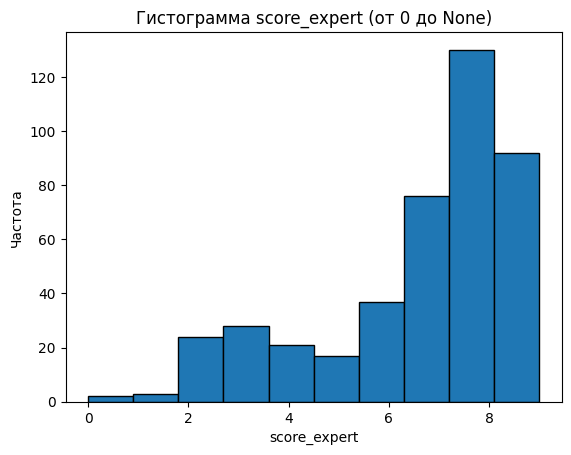

Показано значений: 430 из 430 (100.00%)
Ширина одного бина: 1


In [ ]:
plot_hist(scores, 'score_expert', bins=10)

На первый взгляд - взятая по умолчанию модель отработала не так и плохо. Как оценить качество?

Метрика, которую хочет максимизировать заказчик - доля ответов, признанных положительными и моделью, и экспертом. То есть precision.

При этом заказчик решил считать положительными решениями все оценки выше 6. Определим порог TP_TRESHOLD соответственно.

In [ ]:
TP_THRESHOLD = 6 / 9.0 # оценки выставлялись в диапазоне от 0 до 9

In [ ]:
scores["score_expert_norm"] = scores["score_expert"].astype(float)/9.0
scores['label_expert'] = (scores['score_expert_norm'] > TP_THRESHOLD).astype(int)
scores['label_model'] = 1 # модель посчитала все эти пары максимально похожими

In [ ]:
scores

,id1,id2,score_expert,score_expert_norm,label_expert,label_model
0,IBM-6627,IBM-4382,3.0,0.333333,0,1
1,IBM-7350,IBM-9347,6.0,0.666667,0,1
2,CY-2578,CY-1871,8.0,0.888889,1,1
3,IBM-8043,IBM-7892,8.0,0.888889,1,1
4,IBM-8043,IBM-7898,9.0,1.000000,1,1
...,...,...,...,...,...,...
426,IBM-1874,IBM-1760,6.0,0.666667,0,1
427,CY-257,CY-4055,4.0,0.444444,0,1
428,IBM-10855,IBM-9703,8.0,0.888889,1,1
429,IBM-10855,IBM-7117,7.0,0.777778,1,1


In [ ]:
def compute_precision(labels_expert, labels_model):

    lm = labels_model
    le = labels_expert

    tp = ((le == 1) & (lm == 1)).sum()  # true positive
    fp = ((le == 0) & (lm == 1)).sum()  # false positive
    fn = ((le == 1) & (lm == 0)).sum()  # false negative

    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

In [ ]:
compute_precision(scores['label_expert'].values, scores['label_model'].values)

np.float64(0.6930232558139535)

Надо же, изначально выбранная модель при пороге >6 показала precision 69%. Это уже порадовало заказчика.

Поработаем над улучшением. Для этого проведем дообучение модели.

Источник: https://sbert.net/docs/sentence_transformer/training_overview.html

## 3.2 Готовим данные для дообучения

Загружаем подготовленный ранее датасет с запросами. В колонках:
- id: идентификаторы запросов
- e5_request: тексты запросов, подготовленные для модели E5

In [ ]:
df_requests = pd.read_parquet(DATA_DIR + "requests_with_e5.parquet")
display(df_requests.describe(include='all'))

,subject,id,details_filename,details,details_length,details_no_signs,details_no_signs_length,removed_blocks_count,details_no_signs_emails,details_no_signs_emails_length,...,request_length,request_initials,request_date,conversation,conversation_length,request_full,request_full_lentgth,language,lang_prob,e5_request
count,12797,12797,12797,12797,12797.000000,12797,12797.000000,12797.000000,12797,12797.000000,...,12797.000000,12797,12797,12797,12797.000000,12797,12797.000000,12797,12797.000000,12797
unique,12242,12797,12797,12783,NaN,12780,NaN,NaN,12780,NaN,...,NaN,500,3113,9302,NaN,12556,NaN,3,NaN,12760
top,Lietotāja migrācija,IBM-282,IBM-282.txt,AKO - 14.05.2020\n\nДобрый день!\n\nЧерез 3 не...,NaN,ako - 14.05.2020 добрый день! через 3 недели и...,NaN,NaN,ako - 14.05.2020 добрый день! через 3 недели и...,NaN,...,NaN,,,,NaN,"""",NaN,ru,NaN,query: APNS expiring 07.06.2020 on Traveler\nд...
freq,22,1,1,4,NaN,4,NaN,NaN,4,NaN,...,NaN,1807,1807,3453,NaN,95,NaN,5623,NaN,5
mean,NaN,NaN,NaN,NaN,2465.439947,NaN,2264.881691,0.305384,NaN,2123.322341,...,633.321560,NaN,NaN,NaN,1299.044620,NaN,783.768071,NaN,0.834649,NaN
std,NaN,NaN,NaN,NaN,8193.704091,NaN,7619.245209,1.152439,NaN,6047.435960,...,901.105117,NaN,NaN,NaN,4272.540675,NaN,4104.485427,NaN,0.219257,NaN
min,NaN,NaN,NaN,NaN,3.000000,NaN,1.000000,0.000000,NaN,1.000000,...,1.000000,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,0.074000,NaN
25%,NaN,NaN,NaN,NaN,499.000000,NaN,452.000000,0.000000,NaN,422.000000,...,145.000000,NaN,NaN,NaN,0.000000,NaN,145.000000,NaN,0.771000,NaN
50%,NaN,NaN,NaN,NaN,1105.000000,NaN,1003.000000,0.000000,NaN,943.000000,...,313.000000,NaN,NaN,NaN,314.000000,NaN,313.000000,NaN,0.941000,NaN
75%,NaN,NaN,NaN,NaN,2397.000000,NaN,2173.000000,0.000000,NaN,2052.000000,...,687.000000,NaN,NaN,NaN,1096.000000,NaN,687.000000,NaN,0.988000,NaN


Готовим обучающую и валидационную выборки. Для этого перемешиваем scores и разбиваем в соотношении 80 / 20.

При этом разобьем не случайно, а так, чтобы значение precision в обоих выборках было примерно одинаковым.

Алгоритм, конечно, троглодитский... но вычисляется быстро, так что сойдет.

In [ ]:
for rs in range (1000):
    print(f'{rs} ', end='')
    scores_shuffled = scores.sample(frac=1.0, random_state=rs).reset_index(drop=True)
    val_size = int(len(scores_shuffled) * 0.2)
    train_df = scores_shuffled.iloc[val_size:].reset_index(drop=True)
    val_df = scores_shuffled.iloc[:val_size].reset_index(drop=True)
    train_p = compute_precision(train_df['label_expert'].values, train_df['label_model'].values)
    val_p = compute_precision(val_df['label_expert'].values, val_df['label_model'].values)
    if abs(train_p - val_p) < 0.006: # 0.005 уже не получилось
        break
rs, train_p, val_p

0 1 2 3 4 

(4, np.float64(0.6918604651162791), np.float64(0.6976744186046512))

In [ ]:
train_p - val_p

np.float64(-0.005813953488372103)


Готовим данные в формате, подходящем для SentenceTransformerTrainer:
- sentence1, sentence2: сравниваемые тексты
- label: оценка эксперта 0/1

https://sbert.net/docs/package_reference/sentence_transformer/losses.html

In [ ]:
from datasets import Dataset

def build_dataset(pairs_df, df_requests):

    texts = df_requests.set_index("id")["e5_request"]

    data_dict = {
        "sentence1": pairs_df["id1"].map(texts).astype(str).tolist(),
        "sentence2": pairs_df["id2"].map(texts).astype(str).tolist(),
        "label": pairs_df["label_expert"].tolist(),
    }

    return Dataset.from_dict(data_dict)

In [ ]:
train_dataset = build_dataset(train_df, df_requests)
val_dataset = build_dataset(val_df, df_requests)

In [ ]:
-------

## 3.3 Дообучение

### 3.3.1 Загружаем исходную модель

In [ ]:
MODEL_PATH

'intfloat/multilingual-e5-small'

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(MODEL_PATH) # та же модель, что использовалась для первоначальной выборки похожих

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

### 3.3.2 Выбираем функцию потерь

Так как у нас бинарные метки, используем Contrastive loss. Из документации:

Expects as input two texts and a label of either 0 or 1. If the label == 1, then the distance between the two embeddings is reduced. If the label == 0, then the distance between the embeddings is increased.

https://sbert.net/docs/package_reference/sentence_transformer/losses.html#contrastiveloss

https://www.researchgate.net/publication/4246277_Dimensionality_Reduction_by_Learning_an_Invariant_Mapping

In [ ]:
from sentence_transformers.losses import ContrastiveLoss

loss_fn = ContrastiveLoss(model)

NameError: name 'model' is not defined

### 3.3.3 Задаем аргументы обучения

In [ ]:
FINETUNED_MODEL_DIR = DATA_DIR + "models/" + MODEL_PATH + "-finetuned"
FINETUNED_MODEL_DIR


'drive/MyDrive/Netology/CY/models/intfloat/multilingual-e5-small-finetuned'

In [ ]:
from sentence_transformers import SentenceTransformerTrainingArguments

training_args = SentenceTransformerTrainingArguments(

    output_dir=FINETUNED_MODEL_DIR,

    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_ratio=0.1, # медленный разгон learning rate за 10% шагов (TODO сноска)

    # Параметры для экономии памяти (пока не понадобились)
    #fp16=True,
    #bf16=False,

    report_to="none", # иначе запрашивает интеграцию с wandb. не будем пока возиться
    save_strategy="epoch",  # сохранять модель по окончании каждого прогона
    load_best_model_at_end=True, # вернуться после обучения к лучшей модели
    metric_for_best_model="eval_loss", # выбираем по eval loss
    greater_is_better=False, # по минимальному значению eval loss
    eval_strategy="epoch", # запускать валидацию после каждого прогона
    logging_strategy = "epoch", # а также выводим промежуточные результаты
)

### 3.3.4 Проводим обучение

In [ ]:
from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss_fn
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.027100,0.023982
2,0.023000,0.022470
3,0.020100,0.020980
4,0.017900,0.021369
5,0.015700,0.021127
6,0.013900,0.021265
7,0.013200,0.020949
8,0.012200,0.020786
9,0.011600,0.020870
10,0.010900,0.021112


TrainOutput(global_step=110, training_loss=0.0165637077933008, metrics={'train_runtime': 943.3466, 'train_samples_per_second': 3.647, 'train_steps_per_second': 0.117, 'total_flos': 0.0, 'train_loss': 0.0165637077933008, 'epoch': 10.0})

In [ ]:
trainer.state.best_model_checkpoint

'drive/MyDrive/Netology/CY/models/intfloat/multilingual-e5-small-finetuned/checkpoint-88'

In [ ]:
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('/content/drive/MyDrive/Netology/CY/models/intfloat/multilingual-e5-small-finetuned/checkpoint-88')

### 3.3.5 Вычислим precision, которую выдает дообученная модель.

In [ ]:
import torch
import numpy as np

def tuned_precision(model, ds):
    model.eval()
    with torch.no_grad():
        e1 = model.encode(
            list(ds["sentence1"]),
            batch_size=64,
            convert_to_tensor=True,
            normalize_embeddings=True,
            show_progress_bar=False,
        )
        e2 = model.encode(
            list(ds["sentence2"]),
            batch_size=64,
            convert_to_tensor=True,
            normalize_embeddings=True,
            show_progress_bar=False,
        )
    # эмбеддинги нормализованы, так что вычисляем cosine similarity
    # просто как скалярное произведение
    # результат переносим для дальнейших вычислений в массив numpy
    # а он работает только на CPU
    cos_sim = (e1 * e2).sum(dim=1).cpu().numpy()
    y_pred = (cos_sim > TP_THRESHOLD).astype(int)

    y_true = np.array(ds["label"]) # святая истина от эксперта

    return compute_precision(y_true, y_pred)

In [ ]:
tuned_precision(model, train_dataset)

np.float64(0.8913857677902621)

In [ ]:
tuned_precision(model, val_dataset)

np.float64(0.7866666666666666)

In [ ]:
-------

## 3.4 Испытаем на модели большего размера

Пришлось переключиться на GPU A100 (40 Гб), цена 5.37 unit/hour.

In [ ]:
MODEL_PATH = 'intfloat/multilingual-e5-base'
FINETUNED_MODEL_DIR = DATA_DIR + "models/" + MODEL_PATH + "-finetuned"
FINETUNED_MODEL_DIR

from sentence_transformers import SentenceTransformer

model = SentenceTransformer(MODEL_PATH)

from sentence_transformers.losses import ContrastiveLoss

loss_fn = ContrastiveLoss(model)

from sentence_transformers import SentenceTransformerTrainingArguments

training_args = SentenceTransformerTrainingArguments(

    output_dir=FINETUNED_MODEL_DIR,

    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_ratio=0.1, # медленный разгон learning rate за 10% шагов (TODO сноска)

    # Параметры для экономии памяти (пока не понадобились)
    #fp16=True,
    #bf16=False,

    report_to="none", # иначе запрашивает интеграцию с wandb. не будем пока возиться
    save_strategy="epoch",  # сохранять модель по окончании каждого прогона
    load_best_model_at_end=True, # вернуться после обучения к лучшей модели
    metric_for_best_model="eval_loss", # выбираем по eval loss
    greater_is_better=False, # по минимальному значению eval loss
    eval_strategy="epoch", # запускать валидацию после каждого прогона
    logging_strategy = "epoch", # а также выводим промежуточные результаты
)

from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss_fn
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss
1,0.026800,0.023133
2,0.021800,0.021214
3,0.017900,0.020105
4,0.014800,0.020500
5,0.011700,0.019744
6,0.009900,0.019739
7,0.008100,0.019804
8,0.007100,0.019969
9,0.006600,0.019961
10,0.006100,0.020122


TrainOutput(global_step=110, training_loss=0.013076301867311652, metrics={'train_runtime': 293.712, 'train_samples_per_second': 11.712, 'train_steps_per_second': 0.375, 'total_flos': 0.0, 'train_loss': 0.013076301867311652, 'epoch': 10.0})

In [ ]:
trainer.state.best_model_checkpoint

'drive/MyDrive/Netology/CY/models/intfloat/multilingual-e5-base-finetuned/checkpoint-66'

In [ ]:
tuned_precision(model, train_dataset)

np.float64(0.9596774193548387)

In [ ]:
tuned_precision(model, val_dataset)

np.float64(0.7662337662337663)

In [ ]:
-----

In [ ]:
import gc
def clear_memory(names):
    for name in names:
        try:
            del globals()[name]
        except KeyError:
            pass

    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
clear_memory(['model'])

## 3.5 Модель из другого семейства

In [ ]:
MODEL_PATH = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'

In [ ]:
FINETUNED_MODEL_DIR = DATA_DIR + "models/" + MODEL_PATH + "-finetuned"
FINETUNED_MODEL_DIR

from sentence_transformers import SentenceTransformer

model = SentenceTransformer(MODEL_PATH)

from sentence_transformers.losses import ContrastiveLoss

loss_fn = ContrastiveLoss(model)

from sentence_transformers import SentenceTransformerTrainingArguments

training_args = SentenceTransformerTrainingArguments(

    output_dir=FINETUNED_MODEL_DIR,

    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_ratio=0.1, # медленный разгон learning rate за 10% шагов (TODO сноска)

    # Параметры для экономии памяти (пока не понадобились)
    #fp16=True,
    #bf16=False,

    report_to="none", # иначе запрашивает интеграцию с wandb. не будем пока возиться
    save_strategy="epoch",  # сохранять модель по окончании каждого прогона
    load_best_model_at_end=True, # вернуться после обучения к лучшей модели
    metric_for_best_model="eval_loss", # выбираем по eval loss
    greater_is_better=False, # по минимальному значению eval loss
    eval_strategy="epoch", # запускать валидацию после каждого прогона
    logging_strategy = "epoch", # а также выводим промежуточные результаты
)

from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss_fn
)

trainer.train()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss
1,0.031600,0.026075
2,0.023900,0.024378
3,0.017900,0.024431
4,0.014700,0.022567
5,0.010600,0.021167
6,0.008000,0.021343
7,0.006400,0.020957
8,0.005300,0.020719
9,0.004500,0.020786
10,0.004100,0.020907


TrainOutput(global_step=110, training_loss=0.01271962702951648, metrics={'train_runtime': 173.9037, 'train_samples_per_second': 19.781, 'train_steps_per_second': 0.633, 'total_flos': 0.0, 'train_loss': 0.01271962702951648, 'epoch': 10.0})

In [ ]:
trainer.state.best_model_checkpoint

'drive/MyDrive/Netology/CY/models/sentence-transformers/paraphrase-multilingual-mpnet-base-v2-finetuned/checkpoint-88'

In [ ]:
tuned_precision(model, train_dataset)

np.float64(0.952)

In [ ]:
tuned_precision(model, val_dataset)

np.float64(0.7733333333333333)

Итого Precision на валидационной выборке:

intfloat/multilingual-e5-small: 0.693

intfloat/multilingual-e5-small-finetuned: 0.787

multilingual-e5-base-finetuned: 0.766

paraphrase-multilingual-mpnet-base-v2-finetuned: 0.773